# run all enabled


## set config


In [1]:
DROP_ROUNDTRIPS_FLAG = False
DROP_SAME_OD_TRIPS = True
DROP_DURATION_OUTLIERS = True
DROP_RARE_OD_PAIRS = True
DROP_INVALID_FLAG = True

EXPORT_FLAG = False

## base path and colab setup


In [2]:
import sys
import os

# Adjust the path as needed to reach your project root from the notebook's location
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

project_root

'/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/public_implementation'

In [3]:
from config import PROJECT_ROOT
from pathlib import Path

In [4]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = 'drive/MyDrive/'
    logging.info("Running on Google Colab")
else:
    base_path = str(PROJECT_ROOT)
    logging.info("Running on local environment")

INFO:root:Running on local environment


## 1. Imports


In [5]:
# colab specific imports
import os
import sys
if 'google.colab' in str(get_ipython()):
    import fireducks.pandas as pd
else:
    import pandas as pd

# general imports
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

pd.set_option('display.max_columns', 200)


# Add the src directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '../src'))

In [6]:
# Import utility functions

from data_utils import *

INFO:root:Workspace root: /Users/peterfalterbaum/Documents/Nova/thesis local/implementation/public_implementation/code/..
INFO:root:Data directory path: /Users/peterfalterbaum/Documents/Nova/thesis local/implementation/public_implementation/code/../data/raw/ODiN Data


## Data Loading


In [7]:
data_base_path = base_path + "/data/raw/"
odin_path = data_base_path + "ODiN Data"

df_kinds = pd.read_csv(odin_path + "/tbl_kinds.csv")

df_persons = pd.read_csv(odin_path + "/tbl_persons.csv")

df_questions = pd.read_csv(odin_path + "/tbl_questions.csv")

df_nonserial_moves = pd.read_csv(odin_path + "/tbl_nonserial_moves.csv")

df_question_options = pd.read_csv(odin_path + "/tbl_question_options.csv")

gdf_netherlands = gpd.read_file(
    data_base_path + "location" + "/working_zips.geojson")

## rename column names based on convention


In [8]:
df_nonserial_moves = rename_columns(df_nonserial_moves, df_questions)

FULL_COUNT = len(df_nonserial_moves)

In [9]:
FULL_COUNT

185169

In [10]:
df_persons = rename_columns(df_persons, df_questions)

## merge persons and nonserial moves


In [11]:
# merging persons and non serial moves
df_nonserial_moves = df_nonserial_moves.merge(
    df_persons, on='person_index', how='left')

In [12]:
df_nonserial_moves

,movement_id,motive,main_mode_of_transport_class_movement,train_ride_departure_station,main_mode_of_transport_travel,trip_id,person_index,nature_of_work,activity_duration_(in_minutes),trip_distance_abroad_(in_hectometers),departure_time_class,removed_all_foreign_relocation,ride_transportation_means,timestamp_departure,new_move,trip_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_move,travel_distance_class_in_the_netherlands,role_in_the_main_mode_of_transportation,visited_several_stores,sequence_of_work_trips,timestamp_arrival,destination/purpose,trip_duration_in_the_netherlands_(in_minutes),correction_of_movements_to_journeys,journey_time_abroad_(in_minutes),travel_duration_class_in_the_netherlands,trip_distance_class_in_the_netherlands,new_person,travel_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_ride,group_size_of_train_travel_group,number_of_journeys_displacement,timestamp_rita_arrival,arrival_point_postal_code,the_departure_point_of_the_movement_is_the_arrival_point,postal_code_of_departure_point,airplane_ride_removed,arrival_station_train_ride,departure_location_relocation,movement_number,number_of_car_occupants,travel_time_in_the_netherlands_(in_minutes),correction_due_to_speed,trip_number,class_division_motif,role_in_the_ride_transportation_vehicle,new_ride,ride_transportation_means_class,timestamp_trip_departure,person_id,unique_id_for_each_op,sampling_indicator,number_of_people_in_household,household_composition,place_op_in_household_compared_to_household_core,number_of_household_members_under_6_years_of_age,number_of_household_members_aged_6_to_11,number_of_household_members_aged_12_to_17,number_of_household_members_aged_18_or_older,postal_code_residential_address,neighborhood_combination_amsterdam,amsterdam_metropolitan_region,metropolitan_region_rotterdam_the_hague,province_of_utrecht,gender_op,age_op,age_class_op,migration_background_op,paid_work_op,unpaid_activity_op,social_participation_op,highest_completed_op_education,household_disposable_income_(10%_groups),standardized_household_disposable_income_(10%_groups),deviation_from_low-income_limit,deviation_from_social_minimum,household_prosperity_(10%_groups),number_of_car_licenses_in_household,number_of_motorcycle_licenses_in_household,number_of_moped_licenses_in_household,op_has_a_driving_license_for_a_car,op_possesses_a_motorcycle_license,op_possesses_a_moped_driving_license,number_of_passenger_cars_in_household,number_of_passenger_cars_leased_or_registered_in_the_name_of_a_company_in_the_household,number_of_passenger_cars_registered_in_op's_name,first_fuel_for_youngest_passenger_car_in_household_name,"second_fuel,_youngest_passenger_car_in_household_name","type_of_electric_car,_youngest_passenger_car_in_household_name",year_of_manufacture_of_youngest_passenger_car_in_household_name,year_of_construction_class_of_youngest_passenger_car_in_household_name,weight_class_of_youngest_passenger_car_in_household_name,registration_of_youngest_passenger_car_in_household_name,first_fuel_second_youngest_passenger_car_in_household_name,second_fuel_second_youngest_passenger_car_in_household_name,type_of_electric_car_second_youngest_passenger_car_in_household_name,year_of_construction_second_to_youngest_passenger_car_in_household_name,year_of_construction_class_second_youngest_passenger_car_in_household_name,weight_class_second_youngest_passenger_car_in_household_name,registration_of_the_second_youngest_passenger_car_in_the_name_of_the_household,first_fuel_lease_car_or_passenger_car_in_company_name_in_household,second_fuel_lease_car_or_passenger_car_in_the_name_of_a_company_in_the_household,"type_of_electric_car,_lease_car_or_passenger_car_in_the_name_of_company_in_household",year_of_construction_of_lease_car_or_passenger_car_in_the_name_of_company_in_household,year_of_construction_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,weight_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,number_of_motor

## transform timestamps and postal codes


In [13]:
df_nonserial_moves

,movement_id,motive,main_mode_of_transport_class_movement,train_ride_departure_station,main_mode_of_transport_travel,trip_id,person_index,nature_of_work,activity_duration_(in_minutes),trip_distance_abroad_(in_hectometers),departure_time_class,removed_all_foreign_relocation,ride_transportation_means,timestamp_departure,new_move,trip_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_move,travel_distance_class_in_the_netherlands,role_in_the_main_mode_of_transportation,visited_several_stores,sequence_of_work_trips,timestamp_arrival,destination/purpose,trip_duration_in_the_netherlands_(in_minutes),correction_of_movements_to_journeys,journey_time_abroad_(in_minutes),travel_duration_class_in_the_netherlands,trip_distance_class_in_the_netherlands,new_person,travel_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_ride,group_size_of_train_travel_group,number_of_journeys_displacement,timestamp_rita_arrival,arrival_point_postal_code,the_departure_point_of_the_movement_is_the_arrival_point,postal_code_of_departure_point,airplane_ride_removed,arrival_station_train_ride,departure_location_relocation,movement_number,number_of_car_occupants,travel_time_in_the_netherlands_(in_minutes),correction_due_to_speed,trip_number,class_division_motif,role_in_the_ride_transportation_vehicle,new_ride,ride_transportation_means_class,timestamp_trip_departure,person_id,unique_id_for_each_op,sampling_indicator,number_of_people_in_household,household_composition,place_op_in_household_compared_to_household_core,number_of_household_members_under_6_years_of_age,number_of_household_members_aged_6_to_11,number_of_household_members_aged_12_to_17,number_of_household_members_aged_18_or_older,postal_code_residential_address,neighborhood_combination_amsterdam,amsterdam_metropolitan_region,metropolitan_region_rotterdam_the_hague,province_of_utrecht,gender_op,age_op,age_class_op,migration_background_op,paid_work_op,unpaid_activity_op,social_participation_op,highest_completed_op_education,household_disposable_income_(10%_groups),standardized_household_disposable_income_(10%_groups),deviation_from_low-income_limit,deviation_from_social_minimum,household_prosperity_(10%_groups),number_of_car_licenses_in_household,number_of_motorcycle_licenses_in_household,number_of_moped_licenses_in_household,op_has_a_driving_license_for_a_car,op_possesses_a_motorcycle_license,op_possesses_a_moped_driving_license,number_of_passenger_cars_in_household,number_of_passenger_cars_leased_or_registered_in_the_name_of_a_company_in_the_household,number_of_passenger_cars_registered_in_op's_name,first_fuel_for_youngest_passenger_car_in_household_name,"second_fuel,_youngest_passenger_car_in_household_name","type_of_electric_car,_youngest_passenger_car_in_household_name",year_of_manufacture_of_youngest_passenger_car_in_household_name,year_of_construction_class_of_youngest_passenger_car_in_household_name,weight_class_of_youngest_passenger_car_in_household_name,registration_of_youngest_passenger_car_in_household_name,first_fuel_second_youngest_passenger_car_in_household_name,second_fuel_second_youngest_passenger_car_in_household_name,type_of_electric_car_second_youngest_passenger_car_in_household_name,year_of_construction_second_to_youngest_passenger_car_in_household_name,year_of_construction_class_second_youngest_passenger_car_in_household_name,weight_class_second_youngest_passenger_car_in_household_name,registration_of_the_second_youngest_passenger_car_in_the_name_of_the_household,first_fuel_lease_car_or_passenger_car_in_company_name_in_household,second_fuel_lease_car_or_passenger_car_in_the_name_of_a_company_in_the_household,"type_of_electric_car,_lease_car_or_passenger_car_in_the_name_of_company_in_household",year_of_construction_of_lease_car_or_passenger_car_in_the_name_of_company_in_household,year_of_construction_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,weight_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,number_of_motor

In [14]:
df_nonserial_moves.drop(
    columns=[get_standardized_column_name('Timestamp Rita arrival'), get_standardized_column_name('Timestamp Trip departure')], inplace=True)

In [15]:
# Transform timestamps to datetime format
timestamp_columns = [get_standardized_column_name(
    'Timestamp Departure'), get_standardized_column_name('Timestamp Arrival')]

for df in [df_nonserial_moves]:
    for col in timestamp_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            logging.info(f"Converted {col} to datetime format")

# Transform postal codes to string with exactly 4 digits
postal_code_columns = [get_standardized_column_name(
    'VertPC'), get_standardized_column_name('AankPC')]

for df in [df_nonserial_moves]:
    for col in postal_code_columns:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: f"{int(x):04d}" if pd.notna(x) and x != 0 else np.nan)
            logging.info(f"Formatted {col} to 4-digit string format")

INFO:root:Converted timestamp_departure to datetime format
INFO:root:Converted timestamp_arrival to datetime format
INFO:root:Formatted postal_code_of_departure_point to 4-digit string format
INFO:root:Formatted arrival_point_postal_code to 4-digit string format


In [16]:
df_nonserial_moves

,movement_id,motive,main_mode_of_transport_class_movement,train_ride_departure_station,main_mode_of_transport_travel,trip_id,person_index,nature_of_work,activity_duration_(in_minutes),trip_distance_abroad_(in_hectometers),departure_time_class,removed_all_foreign_relocation,ride_transportation_means,timestamp_departure,new_move,trip_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_move,travel_distance_class_in_the_netherlands,role_in_the_main_mode_of_transportation,visited_several_stores,sequence_of_work_trips,timestamp_arrival,destination/purpose,trip_duration_in_the_netherlands_(in_minutes),correction_of_movements_to_journeys,journey_time_abroad_(in_minutes),travel_duration_class_in_the_netherlands,trip_distance_class_in_the_netherlands,new_person,travel_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_ride,group_size_of_train_travel_group,number_of_journeys_displacement,arrival_point_postal_code,the_departure_point_of_the_movement_is_the_arrival_point,postal_code_of_departure_point,airplane_ride_removed,arrival_station_train_ride,departure_location_relocation,movement_number,number_of_car_occupants,travel_time_in_the_netherlands_(in_minutes),correction_due_to_speed,trip_number,class_division_motif,role_in_the_ride_transportation_vehicle,new_ride,ride_transportation_means_class,person_id,unique_id_for_each_op,sampling_indicator,number_of_people_in_household,household_composition,place_op_in_household_compared_to_household_core,number_of_household_members_under_6_years_of_age,number_of_household_members_aged_6_to_11,number_of_household_members_aged_12_to_17,number_of_household_members_aged_18_or_older,postal_code_residential_address,neighborhood_combination_amsterdam,amsterdam_metropolitan_region,metropolitan_region_rotterdam_the_hague,province_of_utrecht,gender_op,age_op,age_class_op,migration_background_op,paid_work_op,unpaid_activity_op,social_participation_op,highest_completed_op_education,household_disposable_income_(10%_groups),standardized_household_disposable_income_(10%_groups),deviation_from_low-income_limit,deviation_from_social_minimum,household_prosperity_(10%_groups),number_of_car_licenses_in_household,number_of_motorcycle_licenses_in_household,number_of_moped_licenses_in_household,op_has_a_driving_license_for_a_car,op_possesses_a_motorcycle_license,op_possesses_a_moped_driving_license,number_of_passenger_cars_in_household,number_of_passenger_cars_leased_or_registered_in_the_name_of_a_company_in_the_household,number_of_passenger_cars_registered_in_op's_name,first_fuel_for_youngest_passenger_car_in_household_name,"second_fuel,_youngest_passenger_car_in_household_name","type_of_electric_car,_youngest_passenger_car_in_household_name",year_of_manufacture_of_youngest_passenger_car_in_household_name,year_of_construction_class_of_youngest_passenger_car_in_household_name,weight_class_of_youngest_passenger_car_in_household_name,registration_of_youngest_passenger_car_in_household_name,first_fuel_second_youngest_passenger_car_in_household_name,second_fuel_second_youngest_passenger_car_in_household_name,type_of_electric_car_second_youngest_passenger_car_in_household_name,year_of_construction_second_to_youngest_passenger_car_in_household_name,year_of_construction_class_second_youngest_passenger_car_in_household_name,weight_class_second_youngest_passenger_car_in_household_name,registration_of_the_second_youngest_passenger_car_in_the_name_of_the_household,first_fuel_lease_car_or_passenger_car_in_company_name_in_household,second_fuel_lease_car_or_passenger_car_in_the_name_of_a_company_in_the_household,"type_of_electric_car,_lease_car_or_passenger_car_in_the_name_of_company_in_household",year_of_construction_of_lease_car_or_passenger_car_in_the_name_of_company_in_household,year_of_construction_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,weight_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,number_of_motorcycles_in_household,number_of_engines_in_op_name

## remove not valid postal codes


In [17]:
df_nonserial_moves

,movement_id,motive,main_mode_of_transport_class_movement,train_ride_departure_station,main_mode_of_transport_travel,trip_id,person_index,nature_of_work,activity_duration_(in_minutes),trip_distance_abroad_(in_hectometers),departure_time_class,removed_all_foreign_relocation,ride_transportation_means,timestamp_departure,new_move,trip_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_move,travel_distance_class_in_the_netherlands,role_in_the_main_mode_of_transportation,visited_several_stores,sequence_of_work_trips,timestamp_arrival,destination/purpose,trip_duration_in_the_netherlands_(in_minutes),correction_of_movements_to_journeys,journey_time_abroad_(in_minutes),travel_duration_class_in_the_netherlands,trip_distance_class_in_the_netherlands,new_person,travel_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_ride,group_size_of_train_travel_group,number_of_journeys_displacement,arrival_point_postal_code,the_departure_point_of_the_movement_is_the_arrival_point,postal_code_of_departure_point,airplane_ride_removed,arrival_station_train_ride,departure_location_relocation,movement_number,number_of_car_occupants,travel_time_in_the_netherlands_(in_minutes),correction_due_to_speed,trip_number,class_division_motif,role_in_the_ride_transportation_vehicle,new_ride,ride_transportation_means_class,person_id,unique_id_for_each_op,sampling_indicator,number_of_people_in_household,household_composition,place_op_in_household_compared_to_household_core,number_of_household_members_under_6_years_of_age,number_of_household_members_aged_6_to_11,number_of_household_members_aged_12_to_17,number_of_household_members_aged_18_or_older,postal_code_residential_address,neighborhood_combination_amsterdam,amsterdam_metropolitan_region,metropolitan_region_rotterdam_the_hague,province_of_utrecht,gender_op,age_op,age_class_op,migration_background_op,paid_work_op,unpaid_activity_op,social_participation_op,highest_completed_op_education,household_disposable_income_(10%_groups),standardized_household_disposable_income_(10%_groups),deviation_from_low-income_limit,deviation_from_social_minimum,household_prosperity_(10%_groups),number_of_car_licenses_in_household,number_of_motorcycle_licenses_in_household,number_of_moped_licenses_in_household,op_has_a_driving_license_for_a_car,op_possesses_a_motorcycle_license,op_possesses_a_moped_driving_license,number_of_passenger_cars_in_household,number_of_passenger_cars_leased_or_registered_in_the_name_of_a_company_in_the_household,number_of_passenger_cars_registered_in_op's_name,first_fuel_for_youngest_passenger_car_in_household_name,"second_fuel,_youngest_passenger_car_in_household_name","type_of_electric_car,_youngest_passenger_car_in_household_name",year_of_manufacture_of_youngest_passenger_car_in_household_name,year_of_construction_class_of_youngest_passenger_car_in_household_name,weight_class_of_youngest_passenger_car_in_household_name,registration_of_youngest_passenger_car_in_household_name,first_fuel_second_youngest_passenger_car_in_household_name,second_fuel_second_youngest_passenger_car_in_household_name,type_of_electric_car_second_youngest_passenger_car_in_household_name,year_of_construction_second_to_youngest_passenger_car_in_household_name,year_of_construction_class_second_youngest_passenger_car_in_household_name,weight_class_second_youngest_passenger_car_in_household_name,registration_of_the_second_youngest_passenger_car_in_the_name_of_the_household,first_fuel_lease_car_or_passenger_car_in_company_name_in_household,second_fuel_lease_car_or_passenger_car_in_the_name_of_a_company_in_the_household,"type_of_electric_car,_lease_car_or_passenger_car_in_the_name_of_company_in_household",year_of_construction_of_lease_car_or_passenger_car_in_the_name_of_company_in_household,year_of_construction_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,weight_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,number_of_motorcycles_in_household,number_of_engines_in_op_name

In [18]:
if DROP_INVALID_FLAG:
    # Get all valid postal codes from gdf_netherlands
    valid_pc4_codes = set(gdf_netherlands['pc4_code'].astype(str))

    # Count initial number of rows
    initial_count = len(df_nonserial_moves)

    # Create DataFrames to track invalid codes and their counts
    invalid_origin_df = pd.DataFrame({
        'postal_code': df_nonserial_moves[get_standardized_column_name('VertPC')].astype(str),
        'location': 'origin'
    })
    invalid_dest_df = pd.DataFrame({
        'postal_code': df_nonserial_moves[get_standardized_column_name('AankPC')].astype(str),
        'location': 'destination'
    })

    # Combine and count occurrences
    invalid_codes_df = pd.concat([invalid_origin_df, invalid_dest_df])
    invalid_codes_df = invalid_codes_df[~invalid_codes_df['postal_code'].isin(
        valid_pc4_codes)]
    invalid_codes_summary = invalid_codes_df.groupby(
        ['postal_code', 'location']).size().reset_index(name='count')

    # Filter out rows where either origin or destination postal code is invalid
    df_nonserial_moves = df_nonserial_moves[
        df_nonserial_moves[get_standardized_column_name('VertPC')].astype(str).isin(valid_pc4_codes) &
        df_nonserial_moves[get_standardized_column_name(
            'AankPC')].astype(str).isin(valid_pc4_codes)
    ]

    # Calculate and print number of removed entries
    removed_count_invalid_codes = initial_count - len(df_nonserial_moves)
    print(
        f"Removed {removed_count_invalid_codes} entries with invalid postal codes")
    print(f"Remaining entries: {len(df_nonserial_moves)}")
    print("\nInvalid postal codes summary:")
    print(invalid_codes_summary.sort_values(['postal_code', 'location']))

Removed 4603 entries with invalid postal codes
Remaining entries: 180566

Invalid postal codes summary:
  postal_code     location  count
0        3928  destination      1
1         nan  destination   2319
2         nan       origin   2482


In [19]:
df_nonserial_moves

,movement_id,motive,main_mode_of_transport_class_movement,train_ride_departure_station,main_mode_of_transport_travel,trip_id,person_index,nature_of_work,activity_duration_(in_minutes),trip_distance_abroad_(in_hectometers),departure_time_class,removed_all_foreign_relocation,ride_transportation_means,timestamp_departure,new_move,trip_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_move,travel_distance_class_in_the_netherlands,role_in_the_main_mode_of_transportation,visited_several_stores,sequence_of_work_trips,timestamp_arrival,destination/purpose,trip_duration_in_the_netherlands_(in_minutes),correction_of_movements_to_journeys,journey_time_abroad_(in_minutes),travel_duration_class_in_the_netherlands,trip_distance_class_in_the_netherlands,new_person,travel_distance_in_the_netherlands_(in_hectometers),unique_id_for_every_ride,group_size_of_train_travel_group,number_of_journeys_displacement,arrival_point_postal_code,the_departure_point_of_the_movement_is_the_arrival_point,postal_code_of_departure_point,airplane_ride_removed,arrival_station_train_ride,departure_location_relocation,movement_number,number_of_car_occupants,travel_time_in_the_netherlands_(in_minutes),correction_due_to_speed,trip_number,class_division_motif,role_in_the_ride_transportation_vehicle,new_ride,ride_transportation_means_class,person_id,unique_id_for_each_op,sampling_indicator,number_of_people_in_household,household_composition,place_op_in_household_compared_to_household_core,number_of_household_members_under_6_years_of_age,number_of_household_members_aged_6_to_11,number_of_household_members_aged_12_to_17,number_of_household_members_aged_18_or_older,postal_code_residential_address,neighborhood_combination_amsterdam,amsterdam_metropolitan_region,metropolitan_region_rotterdam_the_hague,province_of_utrecht,gender_op,age_op,age_class_op,migration_background_op,paid_work_op,unpaid_activity_op,social_participation_op,highest_completed_op_education,household_disposable_income_(10%_groups),standardized_household_disposable_income_(10%_groups),deviation_from_low-income_limit,deviation_from_social_minimum,household_prosperity_(10%_groups),number_of_car_licenses_in_household,number_of_motorcycle_licenses_in_household,number_of_moped_licenses_in_household,op_has_a_driving_license_for_a_car,op_possesses_a_motorcycle_license,op_possesses_a_moped_driving_license,number_of_passenger_cars_in_household,number_of_passenger_cars_leased_or_registered_in_the_name_of_a_company_in_the_household,number_of_passenger_cars_registered_in_op's_name,first_fuel_for_youngest_passenger_car_in_household_name,"second_fuel,_youngest_passenger_car_in_household_name","type_of_electric_car,_youngest_passenger_car_in_household_name",year_of_manufacture_of_youngest_passenger_car_in_household_name,year_of_construction_class_of_youngest_passenger_car_in_household_name,weight_class_of_youngest_passenger_car_in_household_name,registration_of_youngest_passenger_car_in_household_name,first_fuel_second_youngest_passenger_car_in_household_name,second_fuel_second_youngest_passenger_car_in_household_name,type_of_electric_car_second_youngest_passenger_car_in_household_name,year_of_construction_second_to_youngest_passenger_car_in_household_name,year_of_construction_class_second_youngest_passenger_car_in_household_name,weight_class_second_youngest_passenger_car_in_household_name,registration_of_the_second_youngest_passenger_car_in_the_name_of_the_household,first_fuel_lease_car_or_passenger_car_in_company_name_in_household,second_fuel_lease_car_or_passenger_car_in_the_name_of_a_company_in_the_household,"type_of_electric_car,_lease_car_or_passenger_car_in_the_name_of_company_in_household",year_of_construction_of_lease_car_or_passenger_car_in_the_name_of_company_in_household,year_of_construction_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,weight_class_lease_car_or_passenger_car_in_the_name_of_company_in_household,number_of_motorcycles_in_household,number_of_engines_in_op_name

## opt - remove roundtrips (based on flag)


In [20]:
if DROP_ROUNDTRIPS_FLAG:
    initial_count = len(df_nonserial_moves)
    print(
        f"Total number of roundtrips: {len(df_nonserial_moves[df_nonserial_moves['the_departure_point_of_the_movement_is_the_arrival_point'] == True])}")
    print(f"Total number of trips: {len(df_nonserial_moves)}")
    print(
        f"Percentage of roundtrips: {len(df_nonserial_moves[df_nonserial_moves['the_departure_point_of_the_movement_is_the_arrival_point'] == True]) / len(df_nonserial_moves)}")
    df_nonserial_moves = df_nonserial_moves[df_nonserial_moves[
        "the_departure_point_of_the_movement_is_the_arrival_point"] == False]
    print(
        f"Total number of trips after removing roundtrips: {len(df_nonserial_moves)}")
    removed_count_roundtrips = initial_count - len(df_nonserial_moves)

## opt - remove O=D trips


In [21]:
if DROP_SAME_OD_TRIPS:
    initial_count = len(df_nonserial_moves)
    print(
        f"Total number of O=D trips: {len(df_nonserial_moves[df_nonserial_moves['arrival_point_postal_code'] == df_nonserial_moves['postal_code_of_departure_point']])}")
    print(f"Total number of trips: {len(df_nonserial_moves)}")
    print(
        f"Percentage of O=D trips: {len(df_nonserial_moves[df_nonserial_moves['arrival_point_postal_code'] == df_nonserial_moves['postal_code_of_departure_point']]) / len(df_nonserial_moves)}")
    df_nonserial_moves = df_nonserial_moves[df_nonserial_moves["arrival_point_postal_code"]
                                            != df_nonserial_moves["postal_code_of_departure_point"]]
    print(
        f"Total number of trips after removing O=D trips: {len(df_nonserial_moves)}")
    removed_count_same_od = initial_count - len(df_nonserial_moves)

Total number of O=D trips: 64502
Total number of trips: 180566
Percentage of O=D trips: 0.35722118228237876
Total number of trips after removing O=D trips: 116064


## opt - remove rare OD pairs based on threshold (e.g. > 3 trips)


In [22]:
# # ARCHIVED
# THRESHOLD_RARE_OD_PAIRS = 3
# if DROP_RARE_OD_PAIRS:
#     initial_count = len(df_nonserial_moves)
#     print(f"Total number of trips: {len(df_nonserial_moves)}")

#     # Count occurrences of each OD pair
#     df_od_counts_original = df_nonserial_moves.groupby(
#         ['arrival_point_postal_code', 'postal_code_of_departure_point']).size().reset_index(name='count')

#     print(f"Number of unique OD pairs: {len(df_od_counts_original)}")
#     # Filter out pairs with less than THRESHOLD_RARE_OD_PAIRS occurrences
#     df_od_counts = df_od_counts_original[df_od_counts_original['count']
#                                          >= THRESHOLD_RARE_OD_PAIRS]
#     print(f"Number of unique OD pairs after filtering: {len(df_od_counts)}")

#     df_nonserial_moves = df_nonserial_moves[df_nonserial_moves['arrival_point_postal_code'].isin(
#         df_od_counts['arrival_point_postal_code']) & df_nonserial_moves['postal_code_of_departure_point'].isin(df_od_counts['postal_code_of_departure_point'])]
#     print(
#         f"Total number of trips after removing rare OD pairs: {len(df_nonserial_moves)}")
#     removed_count_rare_od_pairs = initial_count - len(df_nonserial_moves)
#     print(f"Number of trips removed: {removed_count_rare_od_pairs}")

In [23]:
THRESHOLD_RARE_OD_PAIRS = 3
if DROP_RARE_OD_PAIRS:
    initial_count = len(df_nonserial_moves)
    print(f"Total number of trips: {len(df_nonserial_moves)}")

    # Count occurrences of each OD pair
    df_od_counts_original = df_nonserial_moves.groupby(
        ['arrival_point_postal_code', 'postal_code_of_departure_point']).size().reset_index(name='count')

    print(f"Number of unique OD pairs: {len(df_od_counts_original)}")

    # Filter out pairs with less than THRESHOLD_RARE_OD_PAIRS occurrences
    df_od_counts = df_od_counts_original[df_od_counts_original['count']
                                         >= THRESHOLD_RARE_OD_PAIRS]
    print(f"Number of unique OD pairs after filtering: {len(df_od_counts)}")

    # Create a set of valid OD pairs for faster lookup
    valid_od_pairs = set(zip(
        df_od_counts['arrival_point_postal_code'], df_od_counts['postal_code_of_departure_point']))

    # Filter trips based on valid OD pairs
    df_nonserial_moves = df_nonserial_moves[
        df_nonserial_moves.apply(
            lambda row: (row['arrival_point_postal_code'],
                         row['postal_code_of_departure_point']) in valid_od_pairs,
            axis=1
        )
    ]

    print(
        f"Total number of trips after removing rare OD pairs: {len(df_nonserial_moves)}")
    removed_count_rare_od_pairs = initial_count - len(df_nonserial_moves)
    print(f"Number of trips removed: {removed_count_rare_od_pairs}")

Total number of trips: 116064
Number of unique OD pairs: 59954
Number of unique OD pairs after filtering: 12059
Total number of trips after removing rare OD pairs: 60087
Number of trips removed: 55977


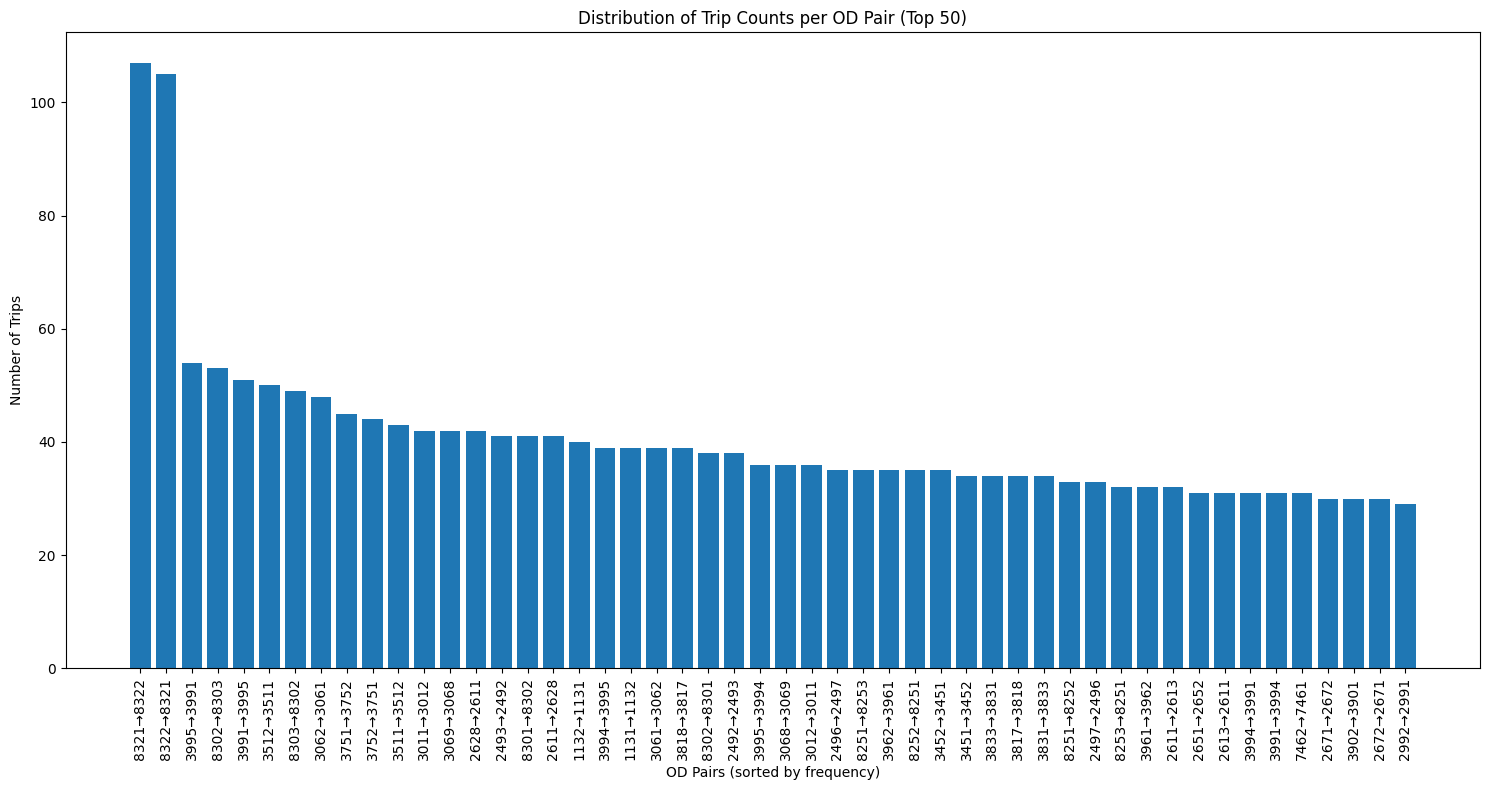


Summary statistics of trip counts per OD pair (Top 50):
count     50.000000
mean      40.500000
std       14.943772
min       29.000000
25%       33.000000
50%       36.000000
75%       42.000000
max      107.000000
Name: count, dtype: float64

Top 10 most frequent OD pairs:
      arrival_point_postal_code postal_code_of_departure_point  count
55435                      8322                           8321    107
55423                      8321                           8322    105
32817                      3991                           3995     54
55203                      8303                           8302     53
32997                      3995                           3991     51
26741                      3511                           3512     50
55159                      8302                           8303     49
21628                      3061                           3062     48
30086                      3752                           3751     45
30061                  

In [24]:
if DROP_RARE_OD_PAIRS:
    # Plot OD combinations and their frequencies
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set figure size for better visibility
    plt.figure(figsize=(15, 8))

    # Sort the data by count in descending order and take top 50
    df_sorted = df_od_counts_original.sort_values(
        'count', ascending=False).head(50)

    # Create bar plot of trip counts
    plt.bar(range(len(df_sorted)), df_sorted['count'])
    plt.title('Distribution of Trip Counts per OD Pair (Top 50)')
    plt.xlabel('OD Pairs (sorted by frequency)')
    plt.ylabel('Number of Trips')

    # Rotate x-axis labels for better readability
    plt.xticks(range(len(df_sorted)),
               [f"{row['postal_code_of_departure_point']}→{row['arrival_point_postal_code']}"
                for _, row in df_sorted.iterrows()],
               rotation=90)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

    # Print summary statistics for top 50
    print("\nSummary statistics of trip counts per OD pair (Top 50):")
    print(df_sorted['count'].describe())

    # Display top 10 most frequent OD pairs
    print("\nTop 10 most frequent OD pairs:")
    print(df_sorted.head(10))

## opt - remove duration outliers


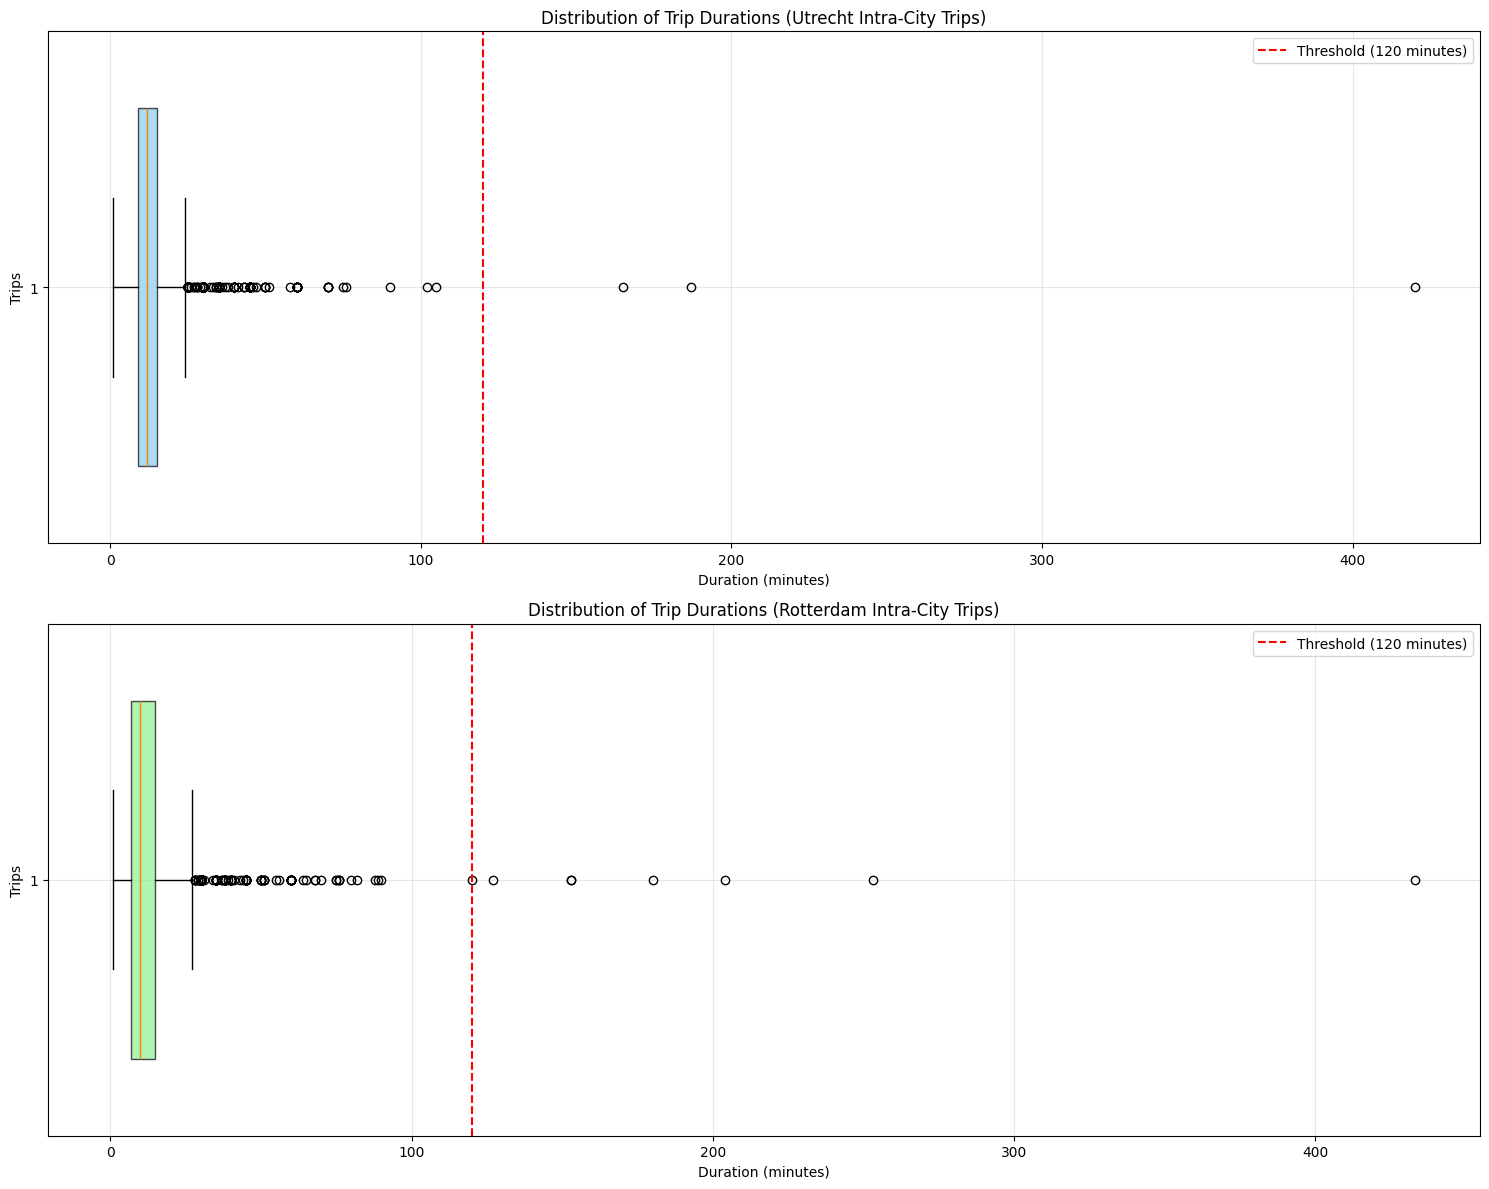


Duration Distribution Table - Utrecht:
                                               Count  Percentage
trip_duration_in_the_netherlands_(in_minutes)                   
0-30                                            2467       97.05
31-60                                             63        2.48
61-120                                             9        0.35
121-180                                            1        0.04
181-240                                            1        0.04
241-300                                            0        0.00
301-400                                            0        0.00
>400                                               1        0.04

Duration Distribution Table - Rotterdam:
                                               Count  Percentage
trip_duration_in_the_netherlands_(in_minutes)                   
0-30                                            3301       96.97
31-60                                             80        2.35
61-120  

In [25]:
THRESHOLD_DURATION = 120
if DROP_DURATION_OUTLIERS:
    initial_count = len(df_nonserial_moves)

    # Load working postal codes for Utrecht and Rotterdam
    working_zips = gpd.read_file(
        '/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/rocket riding/data/raw/location/working_zips.geojson')

    # Get postal codes for each city separately
    utrecht_zips = working_zips[working_zips['gem_name']
                                == 'Utrecht']['pc4_code'].tolist()
    rotterdam_zips = working_zips[working_zips['gem_name']
                                  == 'Rotterdam']['pc4_code'].tolist()

    # Filter for intra-city trips only
    df_utrecht = df_nonserial_moves[
        (df_nonserial_moves['postal_code_of_departure_point'].isin(utrecht_zips)) &
        (df_nonserial_moves['arrival_point_postal_code'].isin(utrecht_zips))
    ]

    df_rotterdam = df_nonserial_moves[
        (df_nonserial_moves['postal_code_of_departure_point'].isin(rotterdam_zips)) &
        (df_nonserial_moves['arrival_point_postal_code'].isin(rotterdam_zips))
    ]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot Utrecht box plot
    box_plot_utrecht = ax1.boxplot(df_utrecht['trip_duration_in_the_netherlands_(in_minutes)'],
                                   vert=False,
                                   patch_artist=True,
                                   widths=0.7)
    for box in box_plot_utrecht['boxes']:
        box.set(facecolor='skyblue', alpha=0.7)
    ax1.axvline(x=THRESHOLD_DURATION, color='red', linestyle='--',
                label=f'Threshold ({THRESHOLD_DURATION} minutes)')
    ax1.set_title('Distribution of Trip Durations (Utrecht Intra-City Trips)')
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('Trips')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Rotterdam box plot
    box_plot_rotterdam = ax2.boxplot(df_rotterdam['trip_duration_in_the_netherlands_(in_minutes)'],
                                     vert=False,
                                     patch_artist=True,
                                     widths=0.7)
    for box in box_plot_rotterdam['boxes']:
        box.set(facecolor='lightgreen', alpha=0.7)
    ax2.axvline(x=THRESHOLD_DURATION, color='red', linestyle='--',
                label=f'Threshold ({THRESHOLD_DURATION} minutes)')
    ax2.set_title(
        'Distribution of Trip Durations (Rotterdam Intra-City Trips)')
    ax2.set_xlabel('Duration (minutes)')
    ax2.set_ylabel('Trips')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create duration bins and count trips for both cities
    bins = [0, 30, 60, 120, 180, 240, 300, 400, float('inf')]
    labels = ['0-30', '31-60', '61-120', '121-180',
              '181-240', '241-300', '301-400', '>400']

    # Calculate duration distributions for both cities
    duration_counts_utrecht = pd.cut(df_utrecht['trip_duration_in_the_netherlands_(in_minutes)'],
                                     bins=bins,
                                     labels=labels).value_counts().sort_index()

    duration_counts_rotterdam = pd.cut(df_rotterdam['trip_duration_in_the_netherlands_(in_minutes)'],
                                       bins=bins,
                                       labels=labels).value_counts().sort_index()

    duration_counts_full = pd.cut(df_nonserial_moves['trip_duration_in_the_netherlands_(in_minutes)'],
                                  bins=bins,
                                  labels=labels).value_counts().sort_index()

    # Create tables with counts and percentages
    duration_table_utrecht = pd.DataFrame({
        'Count': duration_counts_utrecht,
        'Percentage': (duration_counts_utrecht / len(df_utrecht) * 100).round(2)
    })

    duration_table_rotterdam = pd.DataFrame({
        'Count': duration_counts_rotterdam,
        'Percentage': (duration_counts_rotterdam / len(df_rotterdam) * 100).round(2)
    })

    duration_table_full = pd.DataFrame({
        'Count': duration_counts_full,
        'Percentage': (duration_counts_full / len(df_nonserial_moves) * 100).round(2)
    })

    print("\nDuration Distribution Table - Utrecht:")
    print(duration_table_utrecht)
    print("\nDuration Distribution Table - Rotterdam:")
    print(duration_table_rotterdam)

    # Print statistics for both cities
    print(f"\nUtrecht Statistics:")
    print(f"Total number of intra-city trips: {len(df_utrecht)}")
    print(
        f"Number of trips with duration outliers: {len(df_utrecht[df_utrecht['trip_duration_in_the_netherlands_(in_minutes)'] > THRESHOLD_DURATION])}")
    print(
        f"Percentage of trips with duration outliers: {len(df_utrecht[df_utrecht['trip_duration_in_the_netherlands_(in_minutes)'] > THRESHOLD_DURATION]) / len(df_utrecht):.2%}")

    print(f"\nRotterdam Statistics:")
    print(f"Total number of intra-city trips: {len(df_rotterdam)}")
    print(
        f"Number of trips with duration outliers: {len(df_rotterdam[df_rotterdam['trip_duration_in_the_netherlands_(in_minutes)'] > THRESHOLD_DURATION])}")
    print(
        f"Percentage of trips with duration outliers: {len(df_rotterdam[df_rotterdam['trip_duration_in_the_netherlands_(in_minutes)'] > THRESHOLD_DURATION]) / len(df_rotterdam):.2%}")

    # Remove outliers from the full dataset
    df_nonserial_moves = df_nonserial_moves[df_nonserial_moves[
        'trip_duration_in_the_netherlands_(in_minutes)'] <= THRESHOLD_DURATION]
    print(
        f"\nTotal number of trips after removing duration outliers: {len(df_nonserial_moves)}")
    removed_count_duration_outliers = initial_count - len(df_nonserial_moves)

In [26]:
duration_table_full

,Count,Percentage
trip_duration_in_the_netherlands_(in_minutes),,
0-30,56699,94.36
31-60,2616,4.35
61-120,628,1.05
121-180,106,0.18
181-240,22,0.04
241-300,7,0.01
301-400,4,0.01
>400,5,0.01


## summary of removed trips


In [27]:
# Create a dictionary with the summary data
summary_dict = {
    "full_count": int(FULL_COUNT),
    "removed_count_invalid_codes": int(removed_count_invalid_codes if 'removed_count_invalid_codes' in locals() else 0),
    "removed_count_roundtrips": int(removed_count_roundtrips if 'removed_count_roundtrips' in locals() else 0),
    "removed_count_same_od": int(removed_count_same_od if 'removed_count_same_od' in locals() else 0),
    "removed_count_duration_outliers": int(removed_count_duration_outliers if 'removed_count_duration_outliers' in locals() else 0),
    "removed_count_rare_od_pairs": int(removed_count_rare_od_pairs if 'removed_count_rare_od_pairs' in locals() else 0)
}

# Calculate total removed and percentage
total_removed = int(sum(summary_dict.values()) - summary_dict["full_count"])
summary_dict["removed_count_total"] = total_removed
summary_dict["new_count"] = int(summary_dict["full_count"] - total_removed)

# Convert to DataFrame and format numbers
df_summary_removed = pd.DataFrame([summary_dict]).T

# Calculate percentages for each row
df_summary_removed['percentage'] = df_summary_removed[0].apply(
    lambda x: f"{float(x)/summary_dict['full_count']*100:.2f}%" if isinstance(
        x, (int, float)) else x
)

# Format absolute values
df_summary_removed[0] = df_summary_removed[0].apply(
    lambda x: f"{x:.0f}" if isinstance(x, (int, float)) else x
)

# Rename columns for clarity
df_summary_removed.columns = ['absolute', 'percentage']

In [28]:
summary_dict

{'full_count': 185169,
 'removed_count_invalid_codes': 4603,
 'removed_count_roundtrips': 0,
 'removed_count_same_od': 64502,
 'removed_count_duration_outliers': 144,
 'removed_count_rare_od_pairs': 55977,
 'removed_count_total': 125226,
 'new_count': 59943}

In [29]:
df_summary_removed

,absolute,percentage
full_count,185169,100.00%
removed_count_invalid_codes,4603,2.49%
removed_count_roundtrips,0,0.00%
removed_count_same_od,64502,34.83%
removed_count_duration_outliers,144,0.08%
removed_count_rare_od_pairs,55977,30.23%
removed_count_total,125226,67.63%
new_count,59943,32.37%


## save cleaned data


select relevant columns


In [30]:
purpose_questions = [
    'destination/purpose',
    'motive',
    'class_division_motif'
]

In [31]:
df_nonserial_moves[purpose_questions]

,destination/purpose,motive,class_division_motif
15,11,10,7
21,2,1,1
24,1,8,6
25,12,11,7
26,1,11,7
...,...,...,...
185130,8,7,4
185131,1,7,4
185134,1,7,4
185167,11,10,7


In [32]:
person_related_questions = [
    'age_op',
    'postal_code_residential_address'
]

In [33]:
df_nonserial_moves = df_nonserial_moves[['arrival_point_postal_code', 'postal_code_of_departure_point',
                                         'timestamp_departure', 'timestamp_arrival', 'main_mode_of_transport_class_movement'] + purpose_questions + person_related_questions]

In [34]:
# Rename columns to follow consistent naming convention
df_nonserial_moves = df_nonserial_moves.rename(columns={
    'postal_code_of_departure_point': 'pc4_departure',
    'arrival_point_postal_code': 'pc4_arrival',
    # 'timestamp_trip_departure': 'timestamp_departure',
    # 'timestamp_arrival': 'timestamp_arrival',
    'main_mode_of_transport_class_movement': 'mode_of_transport'
})

In [35]:
if EXPORT_FLAG:
    # Save cleaned data with configuration flags in filename
    config_flags = []
    if DROP_ROUNDTRIPS_FLAG:
        config_flags.append('no_roundtrips')
    if DROP_SAME_OD_TRIPS:
        config_flags.append('no_same_od')
    if DROP_DURATION_OUTLIERS:
        config_flags.append('no_outliers')
    if DROP_RARE_OD_PAIRS:
        config_flags.append('no_rare_od')

    # Create filename based on configuration
    filename = 'odt'
    if config_flags:
        filename += '_' + '_'.join(config_flags)
    filename += '.csv'
    filename = "final__purpose_person_" + filename

    # Save the cleaned dataframe
    df_nonserial_moves.to_csv(
        base_path + "/data/processed/" + filename, index=False)
    print(f"Saved cleaned data to {filename}")
    print(len(df_nonserial_moves))

In [36]:
df_nonserial_moves

,pc4_arrival,pc4_departure,timestamp_departure,timestamp_arrival,mode_of_transport,destination/purpose,motive,class_division_motif,age_op,postal_code_residential_address
15,1746,1742,2022-11-28 08:45:00,2022-11-28 08:55:00,1,11,10,7,76,1742
21,6511,6542,2022-10-04 13:30:00,2022-10-04 13:40:00,5,2,1,1,83,6542
24,6542,6511,2022-10-04 18:00:00,2022-10-04 18:10:00,5,1,8,6,83,6542
25,6511,6542,2022-10-04 19:00:00,2022-10-04 19:10:00,5,12,11,7,83,6542
26,6542,6511,2022-10-04 21:00:00,2022-10-04 21:08:00,5,1,11,7,83,6542
...,...,...,...,...,...,...,...,...,...,...
185130,3401,3403,2022-02-05 08:00:00,2022-02-05 08:06:00,6,8,7,4,63,3403
185131,3403,3401,2022-02-05 08:26:00,2022-02-05 08:33:00,6,1,7,4,63,3403
185134,3403,3401,2022-02-05 14:20:00,2022-02-05 14:25:00,5,1,7,4,63,3403
185167,1509,1506,2022-12-08 18:20:00,2022-12-08 18:35:00,1,11,10,7,49,1506


In [37]:
# df_test = pd.read_csv("/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/rocket riding/data/processed/odt_no_same_od_no_rare_od_fixed_thresh.csv")

In [38]:
# df_test

In [39]:
# Get unique postal codes from both columns and create a union set
unique_pc4_arrival = set(df_nonserial_moves['pc4_arrival'].unique())
unique_pc4_departure = set(df_nonserial_moves['pc4_departure'].unique())
unique_pc4_union = unique_pc4_arrival.union(unique_pc4_departure)

print(f"Number of unique pc4_arrival: {len(unique_pc4_arrival)}")
print(f"Number of unique pc4_departure: {len(unique_pc4_departure)}")
print(f"Number of unique pc4 in total (union): {len(unique_pc4_union)}")

Number of unique pc4_arrival: 2328
Number of unique pc4_departure: 2341
Number of unique pc4 in total (union): 2443
